In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchtsmixer import TSMixer
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#add a path to the system path
import sys
sys.path.append('../')
from experiments.datasets import *

seed=42
torch.manual_seed(seed)

# Data

In [2]:
sequence_length = 40
prediction_length = 20
input_channels = 1
n_samples=100
n_timesteps=sequence_length+prediction_length

#generate a Sine dataset
Sine=BetaDataset(n_samples=n_samples, n_timesteps=n_timesteps)
X,ts,ys=Sine.get_X_ts_ys()

Ys=np.array(ys)
X_torch=torch.tensor(Ys[:,:sequence_length]).float().reshape(n_samples,sequence_length,1)
Y_torch=torch.tensor(Ys[:,sequence_length:]).float().reshape(n_samples,prediction_length,1)
print(X_torch.shape,Y_torch.shape)

torch.Size([100, 40, 1]) torch.Size([100, 20, 1])


In [3]:
def split(X_torch,Y_torch,train_ratio=0.7,val_ratio=0.15):
    n_samples = X_torch.size(0)
    train_size = int(n_samples * train_ratio)
    val_size = int(n_samples * val_ratio)

    # Shuffle the indices so we pick train/val/test randomly
    indices = torch.randperm(n_samples)
    train_indices = indices[:train_size]
    val_indices = indices[train_size : train_size + val_size]
    test_indices = indices[train_size + val_size :]

    # Slice into train/val/test
    X_train, Y_train = X_torch[train_indices], Y_torch[train_indices]
    X_val,   Y_val   = X_torch[val_indices],   Y_torch[val_indices]
    X_test,  Y_test  = X_torch[test_indices],  Y_torch[test_indices]

    return X_train,Y_train,X_val,Y_val,X_test,Y_test

class TSDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import copy

def train_tsmixer(
    model,
    X_torch,
    Y_torch,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    epochs=20,
    batch_size=16,
    lr=1e-3,
    device="cuda" if torch.cuda.is_available() else "cpu"
):
    """
    Train the TSMixer model on time-series data (X_torch, Y_torch),
    split into train/val/test in ratios (train_ratio, val_ratio, test_ratio).
    
    Parameters
    ----------
    model : nn.Module
        Your TSMixer model instance.
    X_torch : torch.Tensor
        Input tensor of shape (n_samples, input_channels, sequence_length).
    Y_torch : torch.Tensor
        Target tensor of shape (n_samples, input_channels, prediction_length).
    train_ratio : float
        Fraction of data to use for training.
    val_ratio : float
        Fraction of data to use for validation.
    test_ratio : float
        Fraction of data to use for testing.
    epochs : int
        Number of training epochs.
    batch_size : int
        Batch size for data loading.
    lr : float
        Learning rate for the optimizer.
    device : str
        Device to use for training ('cpu' or 'cuda').

    Returns
    -------
    best_model : nn.Module
        The best TSMixer model (lowest validation loss) after training.
    (train_losses, val_losses) : tuple of lists
        The training and validation losses recorded at each epoch.
    test_loss : float
        Final test set loss, computed using the best model state.
    """
    # ---------------------------------------------------------------------
    # 1. Split Data into Train/Val/Test
    # ---------------------------------------------------------------------
    
    X_train,Y_train,X_val,Y_val,X_test,Y_test = split(X_torch,Y_torch,train_ratio=train_ratio,val_ratio=val_ratio)

    # ---------------------------------------------------------------------
    # 2. Create PyTorch Datasets & DataLoaders
    # ---------------------------------------------------------------------
    train_dataset = TSDataset(X_train, Y_train)
    val_dataset   = TSDataset(X_val, Y_val)
    test_dataset  = TSDataset(X_test, Y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

    # ---------------------------------------------------------------------
    # 3. Set Up Model, Loss, Optimizer
    # ---------------------------------------------------------------------
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # For tracking best model
    best_val_loss = float('inf')
    best_model_state = None

    # For storing loss curves
    train_losses = []
    val_losses = []

    # ---------------------------------------------------------------------
    # 4. Training Loop
    # ---------------------------------------------------------------------
    for epoch in range(epochs):
        # -------------------------
        # Training
        # -------------------------
        model.train()
        total_train_loss = 0.0

        for X_batch, Y_batch in train_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # Forward pass
            pred = model(X_batch)
            loss = criterion(pred, Y_batch)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * X_batch.size(0)

        # Average training loss
        epoch_train_loss = total_train_loss / len(train_loader.dataset)

        # -------------------------
        # Validation
        # -------------------------
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for X_batch, Y_batch in val_loader:
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)

                pred = model(X_batch)
                loss = criterion(pred, Y_batch)
                total_val_loss += loss.item() * X_batch.size(0)

        epoch_val_loss = total_val_loss / len(val_loader.dataset)

        # Store losses for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)

        # Check if this is the best validation so far; if yes, save model state
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_epoch = epoch
            best_model_state = copy.deepcopy(model.state_dict())
        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}]: "
                f"Train Loss: {epoch_train_loss:.4f}, "
                f"Val Loss: {epoch_val_loss:.4f}")

    # ---------------------------------------------------------------------
    # 5. Load the Best Model State
    # ---------------------------------------------------------------------
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # ---------------------------------------------------------------------
    # 6. Final Evaluation on Test Set (using the best model)
    # ---------------------------------------------------------------------
    model.eval()
    total_test_loss = 0.0
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            pred = model(X_batch)
            loss = criterion(pred, Y_batch)
            total_test_loss += loss.item() * X_batch.size(0)

    test_loss = total_test_loss / len(test_loader.dataset)
    print(f"Best Model Test Loss: {test_loss:.4f}, Best Epoch: {best_epoch+1}")

    # Return the best model and the loss curves
    return model, (train_losses, val_losses), test_loss,test_dataset

Epoch [10/200]: Train Loss: 0.2190, Val Loss: 0.2065
Epoch [20/200]: Train Loss: 0.1438, Val Loss: 0.1214
Epoch [30/200]: Train Loss: 0.1455, Val Loss: 0.1015
Epoch [40/200]: Train Loss: 0.2082, Val Loss: 0.0830
Epoch [50/200]: Train Loss: 0.0986, Val Loss: 0.0730
Epoch [60/200]: Train Loss: 0.1174, Val Loss: 0.0619
Epoch [70/200]: Train Loss: 0.1038, Val Loss: 0.0547
Epoch [80/200]: Train Loss: 0.0998, Val Loss: 0.0502
Epoch [90/200]: Train Loss: 0.0981, Val Loss: 0.0490
Epoch [100/200]: Train Loss: 0.0770, Val Loss: 0.0445
Epoch [110/200]: Train Loss: 0.0600, Val Loss: 0.0425
Epoch [120/200]: Train Loss: 0.0614, Val Loss: 0.0426
Epoch [130/200]: Train Loss: 0.0650, Val Loss: 0.0371
Epoch [140/200]: Train Loss: 0.0599, Val Loss: 0.0341
Epoch [150/200]: Train Loss: 0.0842, Val Loss: 0.0371
Epoch [160/200]: Train Loss: 0.0779, Val Loss: 0.0365
Epoch [170/200]: Train Loss: 0.0892, Val Loss: 0.0330
Epoch [180/200]: Train Loss: 0.0522, Val Loss: 0.0334
Epoch [190/200]: Train Loss: 0.0519, 

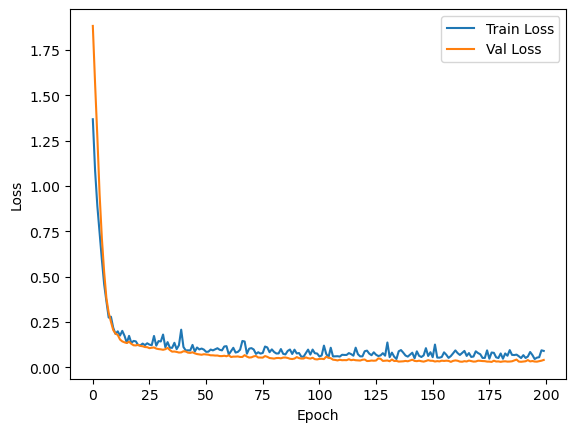

In [5]:
model= TSMixer(
    sequence_length=sequence_length,
    prediction_length=prediction_length,
    input_channels=input_channels,
)

best_model, curves, test_loss,test_dataset  = train_tsmixer(
    model,
    X_torch,
    Y_torch,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    epochs=200,
    batch_size=16,
    lr=1e-3,
    device="cpu"  # or "cpu"
)

plt.plot(curves[0], label='Train Loss')
plt.plot(curves[1], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Generating Bsplines for every sample

In [6]:
from timeview.basis import BSplineBasis
B=5
t=ts[0][sequence_length:]
# Flatten all time arrays together

bspline=BSplineBasis(n_basis=B,t_range=(t[0],t[-1]))
Phis = list(bspline.get_all_matrices(np.array(ts)[:,sequence_length:])) # (D, sequence_length, B)

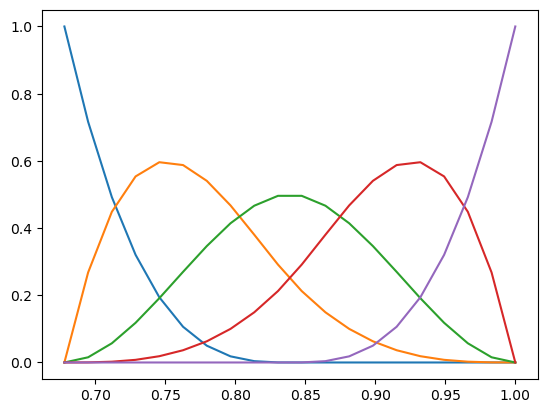

In [7]:
for i in range(B):
    plt.plot(t,Phis[0][:,i])

In [8]:
latent_model = TSMixer(
    sequence_length=sequence_length,   # same as time steps in X
    prediction_length=B, # number of spline coefficients to predict
    input_channels=1,
)

In [9]:
def spline_coeff_loss(criterion, h, Y_batch, Phis):
    y_pred=[torch.matmul(torch.Tensor(Phi),h[d,:]) for d, Phi in enumerate(Phis[:h.shape[0]])]
    y_pred=torch.stack(y_pred)

    loss = criterion(y_pred, Y_batch)
    return loss

In [10]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import copy

def train_tsmixer(
    model,
    X_torch,
    Y_torch,
    Phis,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    epochs=20,
    batch_size=16,
    lr=1e-3,
    device="cuda" if torch.cuda.is_available() else "cpu"
):
    """
    Train the TSMixer model on time-series data (X_torch, Y_torch),
    split into train/val/test in ratios (train_ratio, val_ratio, test_ratio).
    
    Parameters
    ----------
    model : nn.Module
        Your TSMixer model instance.
    X_torch : torch.Tensor
        Input tensor of shape (n_samples, input_channels, sequence_length).
    Y_torch : torch.Tensor
        Target tensor of shape (n_samples, input_channels, prediction_length).
    train_ratio : float
        Fraction of data to use for training.
    val_ratio : float
        Fraction of data to use for validation.
    test_ratio : float
        Fraction of data to use for testing.
    epochs : int
        Number of training epochs.
    batch_size : int
        Batch size for data loading.
    lr : float
        Learning rate for the optimizer.
    device : str
        Device to use for training ('cpu' or 'cuda').

    Returns
    -------
    best_model : nn.Module
        The best TSMixer model (lowest validation loss) after training.
    (train_losses, val_losses) : tuple of lists
        The training and validation losses recorded at each epoch.
    test_loss : float
        Final test set loss, computed using the best model state.
    """
    # ---------------------------------------------------------------------
    # 1. Split Data into Train/Val/Test
    # ---------------------------------------------------------------------

    X_train,Y_train,X_val,Y_val,X_test,Y_test = split(X_torch,Y_torch,train_ratio=train_ratio,val_ratio=val_ratio)

    # ---------------------------------------------------------------------
    # 2. Create PyTorch Datasets & DataLoaders
    # ---------------------------------------------------------------------
    train_dataset = TSDataset(X_train, Y_train)
    val_dataset   = TSDataset(X_val, Y_val)
    test_dataset  = TSDataset(X_test, Y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

    # ---------------------------------------------------------------------
    # 3. Set Up Model, Loss, Optimizer
    # ---------------------------------------------------------------------
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # For tracking best model
    best_val_loss = float('inf')
    best_model_state = None

    # For storing loss curves
    train_losses = []
    val_losses = []

    # ---------------------------------------------------------------------
    # 4. Training Loop
    # ---------------------------------------------------------------------
    for epoch in range(epochs):
        # -------------------------
        # Training
        # -------------------------
        model.train()
        total_train_loss = 0.0

        for X_batch, Y_batch in train_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)


            # Forward pass
            h = model(X_batch)
            loss= spline_coeff_loss(criterion, h, Y_batch, Phis)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item() * X_batch.size(0)

        # Average training loss
        epoch_train_loss = total_train_loss / len(train_loader.dataset)

        # -------------------------
        # Validation
        # -------------------------
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for X_batch, Y_batch in val_loader:
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)

                # Forward pass
                h = model(X_batch)
                loss= spline_coeff_loss(criterion, h, Y_batch, Phis)
                total_val_loss += loss.item() * X_batch.size(0)

        epoch_val_loss = total_val_loss / len(val_loader.dataset)

        # Store losses for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)

        # Check if this is the best validation so far; if yes, save model state
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_epoch = epoch
            best_model_state = copy.deepcopy(model.state_dict())
        if (epoch+1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}]: "
                f"Train Loss: {epoch_train_loss:.4f}, "
                f"Val Loss: {epoch_val_loss:.4f}")

    # ---------------------------------------------------------------------
    # 5. Load the Best Model State
    # ---------------------------------------------------------------------
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    # ---------------------------------------------------------------------
    # 6. Final Evaluation on Test Set (using the best model)
    # ---------------------------------------------------------------------
    model.eval()
    total_test_loss = 0.0
    with torch.no_grad():
        for X_batch, Y_batch in test_loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            h = model(X_batch)
            loss= spline_coeff_loss(criterion, h, Y_batch, Phis)
            total_test_loss += loss.item() * X_batch.size(0)

    test_loss = total_test_loss / len(test_loader.dataset)
    print(f"Best Model Test Loss: {test_loss:.4f}, Best Epoch: {best_epoch+1}")

    # Return the best model and the loss curves
    return model, (train_losses, val_losses), test_loss,test_dataset

Epoch [10/200]: Train Loss: 0.1318, Val Loss: 0.1151
Epoch [20/200]: Train Loss: 0.0845, Val Loss: 0.1145
Epoch [30/200]: Train Loss: 0.0747, Val Loss: 0.0866
Epoch [40/200]: Train Loss: 0.1105, Val Loss: 0.0750
Epoch [50/200]: Train Loss: 0.0473, Val Loss: 0.0578
Epoch [60/200]: Train Loss: 0.0496, Val Loss: 0.0671
Epoch [70/200]: Train Loss: 0.0491, Val Loss: 0.0735
Epoch [80/200]: Train Loss: 0.0359, Val Loss: 0.0451
Epoch [90/200]: Train Loss: 0.0399, Val Loss: 0.0566
Epoch [100/200]: Train Loss: 0.0359, Val Loss: 0.0467
Epoch [110/200]: Train Loss: 0.0719, Val Loss: 0.0375
Epoch [120/200]: Train Loss: 0.0483, Val Loss: 0.0373
Epoch [130/200]: Train Loss: 0.0493, Val Loss: 0.0456
Epoch [140/200]: Train Loss: 0.0771, Val Loss: 0.0393
Epoch [150/200]: Train Loss: 0.0564, Val Loss: 0.0540
Epoch [160/200]: Train Loss: 0.0358, Val Loss: 0.0380
Epoch [170/200]: Train Loss: 0.0385, Val Loss: 0.0406
Epoch [180/200]: Train Loss: 0.0707, Val Loss: 0.0294
Epoch [190/200]: Train Loss: 0.0611, 

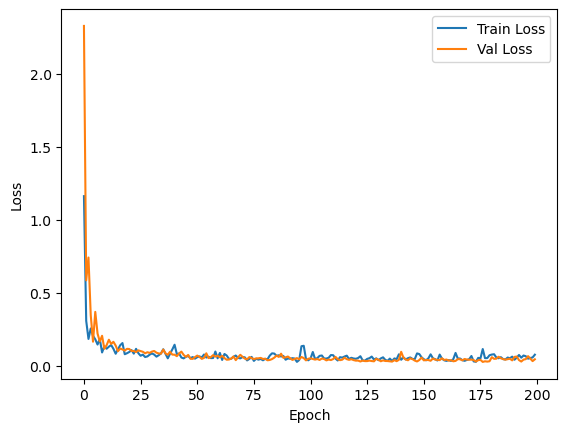

In [11]:
best_latent_model, curves, test_loss,test_dataset = train_tsmixer(
    latent_model,
    X_torch,
    Y_torch,
    Phis,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    epochs=200,
    batch_size=16,
    lr=0.01,
    device="cpu"  # or "cuda"
)

plt.plot(curves[0], label='Train Loss')
plt.plot(curves[1], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

C:\Users\nicolas.i.fierro\AppData\Local\Temp\ipykernel_29552\964085437.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  y_pred=torch.matmul(torch.Tensor(Phis)[0],h_pred).flatten().detach().numpy()


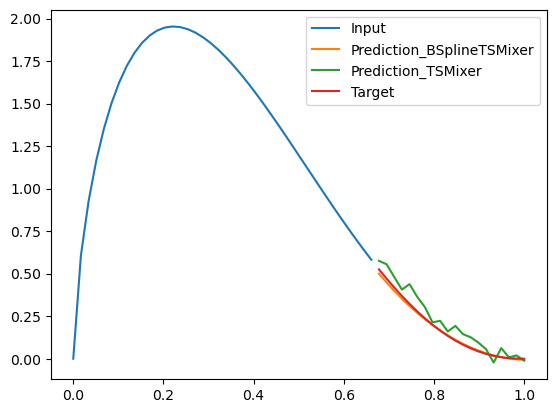

In [12]:
idx=10
x_example=test_dataset.__getitem__(idx)[0]
y_example=test_dataset.__getitem__(idx)[1]

best_latent_model.eval()
with torch.no_grad():
    h_pred = latent_model(x_example.unsqueeze(0))
y_pred=torch.matmul(torch.Tensor(Phis)[0],h_pred).flatten().detach().numpy()

best_model.eval()
with torch.no_grad():
    pred = best_model(x_example.unsqueeze(0))

plt.plot(ts[0][:sequence_length],x_example.squeeze().numpy(), label='Input')
plt.plot(ts[0][sequence_length:],y_pred,label='Prediction_BSplineTSMixer')
plt.plot(ts[0][sequence_length:], pred.squeeze().numpy(), label='Prediction_TSMixer')
plt.plot(ts[0][sequence_length:], y_example.squeeze().numpy(), label='Target')
plt.legend()